In [1]:
import sys
sys.path.append('./crystalformer/src/')

import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree
from hydra import initialize, compose


import checkpoint
from transformer import make_transformer

with initialize(version_base=None, config_path="./model"):
    args = compose(config_name="config")
    print(args)

key = jax.random.PRNGKey(42)
params, transformer = make_transformer(key, args.Nf, args.Kx, args.Kl, args.n_max,
                                        args.h0_size,
                                        4, 8,
                                        32, args.model_size, args.embed_size,
                                        args.atom_types, args.wyck_types,
                                        0.3)


print("\n========== Load checkpoint==========")
restore_path = "./share/"
ckpt_filename, epoch_finished = checkpoint.find_ckpt_filename(restore_path)
if ckpt_filename is not None:
    print("Load checkpoint file: %s, epoch finished: %g" %(ckpt_filename, epoch_finished))
    ckpt = checkpoint.load_data(ckpt_filename)
    params = ckpt["params"]
else:
    print("No checkpoint file found. Start from scratch.")

print ("# of transformer params", ravel_pytree(params)[0].size)


{'epochs': 10000, 'batchsize': 100, 'lr': 0.0001, 'lr_decay': 0.0, 'weight_decay': 0.0, 'clip_grad': 1.0, 'optimizer': 'adam', 'folder': './', 'restore_path': None, 'training_name': '${folder}${optimizer}_bs_${batchsize}_lr_${lr}_decay_${lr_decay}_clip_${clip_grad}', 'train_path': '/data/zdcao/crystal_gpt/dataset/mp_20/train.csv', 'valid_path': '/data/zdcao/crystal_gpt/dataset/mp_20/val.csv', 'test_path': '/data/zdcao/crystal_gpt/dataset/mp_20/test.csv', 'Nf': 5, 'Kx': 16, 'Kl': 4, 'h0_size': 256, 'transformer_layers': 16, 'num_heads': 16, 'key_size': 64, 'model_size': 64, 'embed_size': 32, 'dropout_rate': 0.5, 'transformer_name': 'Nf_${Nf}_Kx_${Kx}_Kl_${Kl}_h0_${h0_size}_l_${transformer_layers}_H_${num_heads}_k_${key_size}_m_${model_size}_e_${embed_size}_drop_${dropout_rate}', 'lamb_a': 1.0, 'lamb_w': 1.0, 'lamb_l': 1.0, 'loss_name': 'a_${lamb_a}_w_${lamb_w}_l_${lamb_l}', 'n_max': 21, 'atom_types': 119, 'wyck_types': 28, 'physics_name': 'A_${atom_types}_W_${wyck_types}_N_${n_max}', 's

In [69]:

import numpy as np
from pymatgen.core import Structure, Lattice
from time import time
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize import view

from sample import sample_crystal
from elements import element_dict, element_list
from scripts.awl2struct import get_struct_from_lawx

jax.config.update("jax_enable_x64", True) # to get off compilation warning, and to prevent sample nan lattice


def generate_and_visualize(spacegroup, elements, temperature, seed):

  print(f"Generating with spacegroup={spacegroup}, elements={elements}, temperature={temperature}")
  
  top_p = 1
  n_sample = 1
  elements = elements.split()
  if elements is not None:
      idx = [element_dict[e] for e in elements]
      atom_mask = [1] + [1 if a in idx else 0 for a in range(1, args.atom_types)]
      atom_mask = jnp.array(atom_mask)
      # print ('sampling structure formed by these elements:', elements)
    #   print (atom_mask)
    #   print("@")
  else:
      atom_mask = jnp.zeros((args.atom_types), dtype=int) # we will do nothing to a_logit in sampling
      print (atom_mask)
  
  # fix
  atom_mask = jnp.repeat(atom_mask.reshape(1, -1), args.n_max, axis=0)
  key = jax.random.PRNGKey(seed)
  key, subkey = jax.random.split(key)
  start_time = time()
#   import pdb
#   pdb.set_trace()
  constraints = jnp.arange(0, args.n_max, 1)
  XYZ, A, W, M, L = sample_crystal(subkey, transformer, params, args.n_max, n_sample, args.atom_types, args.wyck_types, args.Kx, args.Kl, spacegroup, None, atom_mask, top_p, temperature, temperature, constraints)
  end_time = time()
  print("executation time:", end_time - start_time)
  
  XYZ = np.array(XYZ)
  A = np.array(A)
  W = np.array(W)
  L = np.array(L)
  
  G = np.array([spacegroup for i in range(len(L))])
  
  structures = [get_struct_from_lawx(g, l, a, w, xyz) for g, l, a, w, xyz in zip(G, L, A, W, XYZ)]
  structures = [Structure.from_dict(_) for _ in structures]
  
  
  atoms_list = [AseAtomsAdaptor().get_atoms(struct) for struct in structures]
  # return view(atoms_list[0], viewer='ngl'), atoms_list
  # return XYZ, A
  return structures

In [166]:

# ============= params to control the generation =============
spacegroup = 5   # 设置生成的晶体的空间群，范围为1-230
elements = "C"      # 限制生成晶体所包含的元素种类，每个元素需要用空格隔开，比如 "Ba Ti O"
temperature = 0.5  # 控制transformer生成的温度，温度越高生成的novelty越高，推荐值为 0.5到1.5
seed = 42          # 随机种子

# =============== generate and visualization =================
structures = generate_and_visualize(spacegroup, elements, temperature, seed)

Generating with spacegroup=5, elements=C, temperature=0.5
executation time: 3.3169169425964355


In [167]:
structures

[Structure Summary
 Lattice
     abc : 0.7166960440906724 1.0625504331994442 0.10037277227267728
  angles : 90.0 13.519947334850498 90.0
  volume : 0.01786960843091998
       A : -0.16755197985498627 0.0 -0.6968353849094442
       B : 6.506244934751665e-17 -1.0625504331994442 -6.506244934751665e-17
       C : 0.0 0.0 -0.10037277227267728
     pbc : True True True
 PeriodicSite: C (-0.1358, -0.494, -0.6157) [0.8107, 0.4649, 0.5052]
 PeriodicSite: C (-0.05206, -0.494, -0.2662) [0.3107, 0.4649, 0.4948]]

In [168]:
type(structures[0])

pymatgen.core.structure.Structure

In [169]:
abc = structures[0].lattice.abc
pos = structures[0].frac_coords
pos

array([[0.81072813, 0.46489343, 0.50520343],
       [0.31072813, 0.46489343, 0.49479657]])

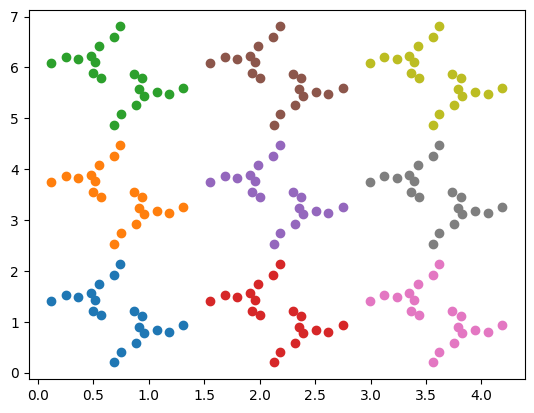

In [165]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
x = pos[:,0]*abc[0]
y = pos[:,1]*abc[1]
# x = np.array([x[2],x[1],x[2],x[0],x[2]+abc[0]])
# y = np.array([y[2]+abc[1],y[1],y[2],y[0],y[2]])
for i in range(3):
    for j in range(3):
        ax.scatter(x+i*abc[0],y+j*abc[1])
        # ax.plot(x+i*abc[0],y+j*abc[1])
        # ax.plot()